In [311]:
import importlib

import os
import sys
import glob

sys.path.insert(0, "../../code/analysis_code/")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import plotly.graph_objects as go

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.sandbox.stats.multicomp import multipletests

import nibabel as nib 
import nilearn.plotting as plotting
from nilearn import datasets
from nilearn import surface

from nilearn import input_data, image


import utils
importlib.reload(utils)

<module 'utils' from '../../code/analysis_code/utils.py'>

In [340]:
sns.set_context('notebook', font_scale=1.5)

In [290]:
demo_data = pd.read_csv("../../data/XXY/xxy_3tc_demo_data.csv", index_col=0)

In [701]:
hcp_orig_img = nib.load("/Users/levitise2/code/BrainsForPublication/required_data/fsaverageSubP/parcellation/HCP.nii.gz")
hcp_data = hcp_orig_img.get_fdata()

# set all the values that aren't in the proper HCP ROIs to 0 and renumber the remaining ones
hcp_data[hcp_data < 1001] = 0
idx = 0
for val in sorted(list(set(hcp_data.flatten()))): 
    hcp_data[hcp_data == val] = idx 
    idx += 1

hcp_renum_img = nib.Nifti1Image(hcp_data, hcp_orig_img.affine, hcp_orig_img.header)

In [521]:
hcp_roi_labels_df = pd.read_csv("../../data/glasser_2016_roi_info.csv")
hcp_roi_labels_df['AreaNameLC'] = [x.lower() for x in hcp_roi_labels_df['AreaName']]

In [522]:
hcp_roi_labels_df.head()

,ParcelIndex,AreaName,AreaDescription,New?,Sections,Other Names,Key Studies,AreaNameLC
0,1,V1,Primary Visual Cortex,No,"1,2","17, hOC1, OC, BA17","Amunts et al 2000, Fischl et al 2008, Abdollah...",v1
1,2,MST,Medial Superior\nTemporal Area,No,"5,15","MSTv, hOC5, hOC5v","Abdollahi et al 2014, Kolster et al 2010, Mali...",mst
2,3,V6,Sixth Visual Area,No,"2,3,18",112,"Pitzalis et al 2006, Pitzalis et al 2013, Sere...",v6
3,4,V2,Second Visual Area,No,"1,2","18, hOC2, OB, BA18","Amunts et al 2000, Fischl et al 2008, Schira e...",v2
4,5,V3,Third Visual Area,No,2,"V3d, V3v, VP,\nhOC3d, hOC3v","Abdollahi et al 2014, Rottschy et al 2007, Sch...",v3


In [291]:
euler_data = pd.read_csv("../../data/XXY/00_group2_stats_tables/euler.tsv", sep="\t")
euler_data['subject'] = [x.split("-")[1] for x in euler_data['subject']]

In [298]:
subs_radiology_pass = demo_data[demo_data.radiology_normal_abnormal != "Abnormal"].PseudoGUID
subs_nonsibs = demo_data[demo_data.DX_GROUP != 'XXYSIB'].PseudoGUID
subs_euler_pass = euler_data[euler_data.mean_euler_bh > -217].subject
subs_males = demo_data[demo_data.SEX != 'F'].PseudoGUID
subs_t1w_qc_pass = list(set(subs_radiology_pass) & set(subs_euler_pass) & set(subs_nonsibs) & set(subs_males))

subs_fmriprep_fail = ['NDARINVRZ901TCJ']
subs_fmri_liv_pass = list(demo_data[demo_data.fmri_in_or_out_liv == "in"].PseudoGUID)
subs_fmri_pass = [sub for sub in subs_fmri_liv_pass if sub not in subs_fmriprep_fail]

subs_fmri_pass = list(set(subs_fmri_pass) & set(subs_t1w_qc_pass))

In [299]:
subs_fmri_liv_pass

['NDARINVGP816PKC',
 'NDARINVXW887PVW',
 'NDARINVDN737BCT',
 'NDARINVHT409RM1',
 'NDARINVZV150HV3',
 'NDARINVBU20JWE1',
 'NDARINVJJ658YVA',
 'NDARINVYU447CLU',
 'NDARINVJR180JRJ',
 'NDARINVPM354FFP',
 'NDARINVMW787LW0',
 'NDARINVDD932JUP',
 'NDARINVER472KE1',
 'NDARINVMC752VBW',
 'NDARINVHA457HDT',
 'NDARINVCG765VFQ',
 'NDARINVBV540WBB',
 'NDARINVMA971HWE',
 'NDARINVKP115VUA',
 'NDARINVPN970KYM',
 'NDARINVLB500YUL',
 'NDARINVKT060CCW',
 'NDARINVFM529DGG',
 'NDARINVRF808GFD',
 'NDARINVKW816XLB',
 'NDARINVWN857DFD',
 'NDARINVUN421ZW9',
 'NDARINVAJTYNUJ0',
 'NDARINVZL673DKL',
 'NDARINVPH133YXN',
 'NDARINVRV544MUB',
 'NDARINVEM105EFN',
 'NDARINVLY144DZ5',
 'NDARINVBV337MTB',
 'NDARINVXE524MYB',
 'NDARINVEF820UW0',
 'NDARINVJY238KZH',
 'NDARINVBK159UMX',
 'NDARINVMB981WXB',
 'NDARINVEP709VW4',
 'NDARINVDY355BGT',
 'NDARINVAT544RN8',
 'NDARINVFV821KNX',
 'NDARINVWB133PX8',
 'NDARINVTN275UW4',
 'NDARINVEU843EDG',
 'NDARINVEA300TAP',
 'NDARINVNU096LJG',
 'NDARINVUW844XR3',
 'NDARINVYY972ETD',


In [227]:
len(subs_fmri_liv_pass)

240

In [228]:
len(subs_fmri_pass)

184

In [229]:
# frames that have excessive motion are already filtered out using 

len(subs_fmri_pass)

184

# QC based on fMRIPrep

- MRIQC uses AFNI 3dvolreg for computing the motion estimate 
- fMRIPrep uses FSL's mcflirt

In [316]:
confound_files = sorted(glob.glob("/Users/levitise2/data/XXY/Nifti/derivatives/fmriprep/sub-NDARINV*/ses-v01/func/*confounds_timeseries.tsv"))
fmriprep_subjects = [x.split("/")[-1].split("_")[0].split("-")[1] for x in confound_files]

In [318]:
fmriprep_qc_agg_df = pd.DataFrame(index=fmriprep_subjects, columns=['FD_Mean'])

In [354]:
for file in confound_files:
    sub = file.split("/")[-1].split("_")[0].split("-")[1]
    curr_df = pd.read_csv(file, sep="\t")
    fd_mean = np.mean(curr_df.framewise_displacement)
    fmriprep_qc_agg_df.loc[sub, 'fd_mean'] = fd_mean

In [330]:
bold_mriqc_df = pd.read_csv("/Users/levitise2/data/XXY/Nifti/derivatives/MRIQC/group_bold.tsv", sep='\t', index_col='bids_name')
bold_mriqc_df.index = [x.split('_')[0].split('-')[1] for x in bold_mriqc_df.index]
bold_mriqc_df = bold_mriqc_df.drop('NDARINVPY148GH1', axis=0)

/Users/levitise2/env/dnu_bids/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean FD comparison across tools')

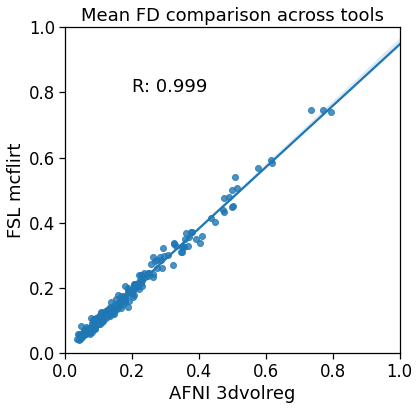

In [356]:
plt.figure(figsize=(6,6))
sns.regplot(list(bold_mriqc_df.fd_mean), list(fmriprep_qc_agg_df.fd_mean))
plt.xlim([0,1])
plt.ylim([0,1])
r,p = stats.pearsonr(list(bold_mriqc_df.fd_mean), list(fmriprep_qc_agg_df.fd_mean))
plt.xlabel("AFNI 3dvolreg")
plt.ylabel("FSL mcflirt")
plt.text(s='R: {0}'.format(np.round(r,3)),x=0.2, y=0.8)
plt.title("Mean FD comparison across tools")

In [358]:
for threshold in [0.2, 0.25, 0.3]:
    n_excluded = len(fmriprep_qc_agg_df[fmriprep_qc_agg_df.fd_mean > threshold])
    print(f'threshold: {threshold} | # excluded: {n_excluded}')

threshold: 0.2 | # excluded: 73
threshold: 0.25 | # excluded: 48
threshold: 0.3 | # excluded: 38


In [359]:
subs_mriqc_pass_fd = list(fmriprep_qc_agg_df[fmriprep_qc_agg_df.fd_mean <= 0.3].index)
subs_mriqc_fail_fd = list(fmriprep_qc_agg_df[fmriprep_qc_agg_df.fd_mean > 0.3].index)

subs_fmri_full_pass = [x for x in subs_fmri_pass if x not in subs_mriqc_fail_fd]

In [360]:
bold_mriqc_df[bold_mriqc_df.index=='NDARINVAY780RMW']

,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,...,summary_bg_stdv,summary_fg_k,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr
NDARINVAY780RMW,0.011752,0.004098,2,32.585401,1.22882,1.073195,0.467721,72339.289062,0.323736,157,...,96.73864,0.416268,664.198242,2078.124023,1991.040283,50020.0,1134.286395,3290.472583,681.26123,50.41114


In [703]:
len(subs_fmri_full_pass)

153

In [362]:
demo_data.head()

,MASK_3TC,fmri_in_or_out_liv,why_fmri_out,Exam_Num,Exam_Num_2,Exam_Num_3,MRN,FAM_NAME,LAST_NAME,FIRST_NAME,...,RT_acquired_at_scan,mp_rage_1_mm,me_mp_rage_1_mm,axial_epi_resting_fMRI,sag_cube_t2,sag_cube_t2_IC,orig_sag_cube_t2_noIC,edti_2mm,t2_fat_sat,PseudoGUID
0,658,in,NaN,17289,NaN,NaN,7807065,Van Buskirk,Van Buskirk,Owen,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,NDARINVGP816PKC
1,659,in,NaN,17309,NaN,NaN,7757517,Velz,Velz,Aria,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,NDARINVXW887PVW
2,660,in,NaN,17312,NaN,NaN,4889423,Taylor,Taylor,Pierce,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,NDARINVDN737BCT
3,661,in,NaN,17412,NaN,NaN,4845018,Halvorson,Halvorson,Jennifer,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,NDARINVHT409RM1
4,662,in,NaN,17478,NaN,NaN,4245404,Hohman,Hohman,William,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,NDARINVZV150HV3


In [363]:
# compare with ethan's assessment
ethan_fmri_qc = pd.read_csv("/Users/levitise2/Documents/XXYQC_3PCs_q_rd.csv")
for i in ethan_fmri_qc.index: 
    mask_id = ethan_fmri_qc.loc[i, 'MaskID']
    ethan_fmri_qc.loc[i, 'PseudoGUID'] = demo_data[demo_data.MASK_3TC == mask_id].PseudoGUID.values[0]

In [364]:
for sub in ethan_fmri_qc.index: 
    pseudoguid=ethan_fmri_qc.loc[sub, 'PseudoGUID']
    if pseudoguid in fmriprep_qc_agg_df.index:
        mriqc_fd_mean = fmriprep_qc_agg_df[fmriprep_qc_agg_df.index==pseudoguid].fd_mean.values[0]
        ethan_fmri_qc.loc[sub, 'MRIQC_FD_Mean'] = mriqc_fd_mean
    else: 
        ethan_fmri_qc.loc[sub, 'MRIQC_FD_Mean'] = ethan_fmri_qc.loc[sub, 'Motion']

/Users/levitise2/env/dnu_bids/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.0, 0.6)

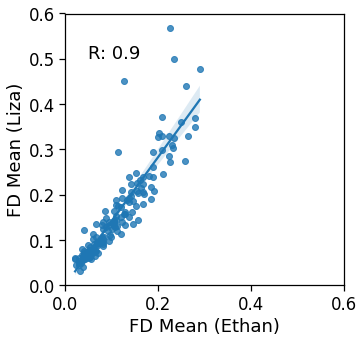

In [371]:
plt.figure(figsize=(5,5))
sns.regplot(ethan_fmri_qc.Motion, ethan_fmri_qc.MRIQC_FD_Mean)
plt.xlabel('FD Mean (Ethan)')
plt.ylabel('FD Mean (Liza)')
r,p = stats.pearsonr(ethan_fmri_qc.Motion, ethan_fmri_qc.MRIQC_FD_Mean)
plt.text(s='R: {0}'.format(np.round(r, 2)), x=0.05, y=0.5)
plt.xlim([0,0.6])
plt.ylim([0,0.6])

In [372]:
ethan_fmri_qc[ethan_fmri_qc.PseudoGUID=='NDARINVLY144DZ5']

,MaskID,Group,Age,Motion,tSNR,Gsmean,Gsrange,PseudoGUID,MRIQC_FD_Mean
10,690,XXY,11.4,0.224491,58.7052,0.3862,2.3978,NDARINVLY144DZ5,0.328989


In [373]:
[x for x in ethan_fmri_qc['PseudoGUID'] if x not in subs_fmri_full_pass]

['NDARINVPN970KYM',
 'NDARINVLY144DZ5',
 'NDARINVYR182VVB',
 'NDARINVYF027FCM',
 'NDARINVXL074DYR',
 'NDARINVJZ279LGC',
 'NDARINVAU691EXN',
 'NDARINVUU711ZVZ',
 'NDARINVGG524NC8',
 'NDARINVBU20JWE1',
 'NDARINVJM938CB6',
 'NDARINVMM669ZH9',
 'NDARINVNZ954VVY',
 'NDARINVMC661LAK',
 'NDARINVRV337MWQ',
 'NDARINVGD340EAP',
 'NDARINVTK126ZMX',
 'NDARINVZD431ATF',
 'NDARINVPV960JDT']

In [374]:
[x for x in subs_fmri_full_pass if x not in list(ethan_fmri_qc['PseudoGUID'])]

['NDARINVGT441RDJ',
 'NDARINVFM425KYW',
 'NDARINVAD840JX2',
 'NDARINVUG394FV7',
 'NDARINVDT130GN9',
 'NDARINVPY048YZ0',
 'NDARINVNU096LJG',
 'NDARINVFK651PKK',
 'NDARINVKR081JEM',
 'NDARINVYG005XNZ',
 'NDARINVHU229ULK',
 'NDARINVHU219TPV',
 'NDARINVZL720GVZ']

In [375]:
len(subs_fmri_full_pass)

153

# Determine which ROIs to remove

In [568]:
# go through the missing.txt files 
glasser_missing_rois_files = sorted(glob.glob('/Users/levitise2/data/XXY/Nifti/derivatives/xcpOutputMNI/sub-*/ses-v01/fcon/glasser360/*_glasser360_missing.txt'))

glasser_missing_rois = {}
all_rois_missing = []
for file in glasser_missing_rois_files:
    sub = file.split("/")[-1].split("_")[0].split("-")[1]
    with open(file, 'r') as f: 
        curr_miss_rois = f.read().split("\n")[:-1]
        # remove trailing whitespace and convert each string to an int
        curr_miss_rois = [int(x.rstrip()) for x in curr_miss_rois]
        glasser_missing_rois[sub] = curr_miss_rois
        all_rois_missing.append(curr_miss_rois)

In [573]:
rois_missing_flattened = sorted(list(set([y for x in all_rois_missing for y in x])))

In [669]:
with open('../../data/hcp_rois.txt', 'r') as f:
    hcp_rois_orig = f.read().split("\n")[:-1]

In [670]:
# need to change some '_' to '-' to match with proper HCP naming convention
hcp_rois = []
for roi in hcp_rois_orig:
    for roi2 in ['p9_46v', 'a9_46v', '9_46d', 'i6_8', 's6_8', 'OP2_3']: 
        if roi2 in roi:
            roi2_new = roi2.replace("_", "-")
            roi = roi.replace(roi2, roi2_new)
    hcp_rois.append(roi)

In [380]:
# identify subjects for whom it's not just [53, 103, 199, 283] missing --> QC those subs, remove if needed

for sub in glasser_missing_rois: 
    #if glasser_missing_rois[sub] != [53, 103, 199, 283]: 
    print(sub, glasser_missing_rois[sub])

NDARINV8XENUGU9 [53, 103, 199, 283]
NDARINVAA410RM8 [53, 103, 199, 283]
NDARINVAA761WNV [53, 103, 199, 283]
NDARINVAD895ZW9 [53, 103, 199, 283]
NDARINVAJ501KPR [53, 103, 199, 283]
NDARINVAJ556GE7 [53, 103, 199, 283]
NDARINVAJTYNUJ0 [53, 103, 199, 283]
NDARINVAM468CWJ [53, 103, 199, 283]
NDARINVAR066BA8 [53, 103, 199, 283]
NDARINVAT479BEW [53, 103, 199, 283]
NDARINVAT544RN8 [53, 103, 199, 283]
NDARINVAU691EXN [53, 103, 199, 283]
NDARINVAU917JX9 [53, 103, 199, 283]
NDARINVAV854FH6 [53, 103, 199, 283]
NDARINVAY227GUG [53, 103, 199, 283]
NDARINVAY780RMW [53, 103, 199, 283]
NDARINVBJ493ZWN [53, 103, 199, 283]
NDARINVBK159UMX [53, 103, 199, 283]
NDARINVBM253CVM [53, 103, 199, 283]
NDARINVBV337MTB [53, 103, 199, 283]
NDARINVBV540WBB [53, 103, 199, 283]
NDARINVBW509KVV [53, 103, 199, 283]
NDARINVBX099WJM [53, 103, 199, 283]
NDARINVBX869XN3 [53, 103, 164, 199, 283, 344]
NDARINVBY016XH3 [53, 103, 199, 283]
NDARINVBZ354NH9 [53, 103, 199, 283]
NDARINVCB763UW6 [53, 103, 199, 283]
NDARINVCG765VFQ [5

In [579]:
# compute degree of each node for all people (vector of nodal degrees --> run a t-test between cases and controls with motion and age as a covariate)

# ReHo and ALFF outputs from xcpEngine

In [680]:
reho_mean_files = sorted(glob.glob('/Users/levitise2/data/XXY/Nifti/derivatives/xcpOutputMNI/sub-*/ses-v01/roiquant/glasser360/*_glasser360_mean_reho.csv'))
alff_mean_files = sorted(glob.glob('/Users/levitise2/data/XXY/Nifti/derivatives/xcpOutputMNI/sub-*/ses-v01/roiquant/glasser360/*_glasser360_mean_alff.csv'))
quality_files = sorted(glob.glob('/Users/levitise2/data/XXY/Nifti/derivatives/xcpOutputMNI/sub-*/ses-v01/*quality.csv'))

In [681]:
len(reho_mean_files)

226

In [682]:
func_subs_processed = [x.split("/")[-1].split("_")[0].split("-")[1] for x in reho_mean_files]

In [683]:
reho_glasser_df = pd.DataFrame(index=func_subs_processed, columns=hcp_rois)
alff_glasser_df = pd.DataFrame(index=func_subs_processed, columns=hcp_rois)

In [684]:
for i, func_lc_df in enumerate([reho_glasser_df, alff_glasser_df]):
    if i == 0:
        file_list = reho_mean_files
    else: 
        file_list = alff_mean_files
    for filename in file_list:
        sub = filename.split("/")[-1].split("_")[0].split("-")[1]
        curr_df = pd.read_csv(filename, index_col=None, header=0)
        curr_df = curr_df[curr_df.columns[2:-1]]
        curr_df.columns = ['rh_R_{0}_ROI'.format(x.split('_')[-1]) if x.split('_')[-2] == 'Right' else 'lh_L_{0}_ROI'.format(x.split('_')[-1]) for x in curr_df.columns]
        curr_rois = curr_df.columns
    #     reho_glasser_df.loc[sub, curr_rois] = curr_df[curr_rois]

        for roi in curr_df.columns:
            func_lc_df.loc[sub, roi] = curr_df[roi].values[0]

In [685]:
reho_glasser_df.head()

,lh_L_V1_ROI,lh_L_MST_ROI,lh_L_V6_ROI,lh_L_V2_ROI,lh_L_V3_ROI,lh_L_V4_ROI,lh_L_V8_ROI,lh_L_4_ROI,lh_L_3b_ROI,lh_L_FEF_ROI,...,rh_R_p47r_ROI,rh_R_TGv_ROI,rh_R_MBelt_ROI,rh_R_LBelt_ROI,rh_R_A4_ROI,rh_R_STSva_ROI,rh_R_TE1m_ROI,rh_R_PI_ROI,rh_R_a32pr_ROI,rh_R_p24_ROI
NDARINV8XENUGU9,0.601146,0.421821,0.55946,0.555858,0.531303,0.502399,0.468736,0.408857,0.440004,0.350002,...,0.467419,0.256986,0.489985,0.380928,0.387461,0.502615,NaN,0.293808,0.400885,0.470393
NDARINVAA410RM8,0.491568,0.479561,0.572259,0.429438,0.384509,0.342847,0.266506,0.397204,0.458131,0.441247,...,0.513761,0.327332,0.501535,0.45001,0.401383,0.350809,NaN,0.357096,0.455231,0.469988
NDARINVAA761WNV,0.638954,0.666965,0.585572,0.578117,0.568956,0.594723,0.481355,0.528258,0.576576,0.39849,...,0.582355,0.42749,0.530707,0.507819,0.450741,0.362571,0.225164,0.335524,0.430656,0.451261
NDARINVAD895ZW9,0.629849,0.542469,0.650023,0.550257,0.560243,0.506845,0.409421,0.540972,0.594,0.466236,...,0.448295,0.375225,0.508634,0.647167,0.503154,0.330409,NaN,0.342637,0.484407,0.589776
NDARINVAJ501KPR,0.411332,0.317149,0.353185,0.402967,0.34893,0.325839,0.263678,0.431175,0.499351,0.517328,...,0.503228,0.281241,0.449515,0.516102,0.304219,0.215036,0.17427,0.366261,0.433071,0.365453


In [688]:
fig = px.box(quality_df, 
             y=["coregCrossCorr", "coregJaccard", "coregCoverage"], 
             color="variable",
             points="all")
fig.show()

In [690]:
reho_glasser_df[reho_glasser_df.index.isin(subs_fmri_full_pass)].isna().sum().sum()

1291

In [691]:
reho_glasser_df.isna().sum()

lh_L_V1_ROI        0
lh_L_MST_ROI       0
lh_L_V6_ROI        0
lh_L_V2_ROI        0
lh_L_V3_ROI        0
                  ..
rh_R_STSva_ROI     0
rh_R_TE1m_ROI     68
rh_R_PI_ROI        0
rh_R_a32pr_ROI     0
rh_R_p24_ROI       0
Length: 360, dtype: int64

In [697]:
func_missing_rois = reho_glasser_df[reho_glasser_df.index.isin(subs_fmri_full_pass)].isna().sum().sort_values(ascending=False)
func_missing_rois = func_missing_rois.to_frame()
func_missing_rois.columns = ['count']
func_missing_rois.index.names = ['Name']

func_missing_rois['Name'] = func_missing_rois.index
for roi in func_missing_rois.index: 
    base = roi.split("_")[2]
    hemi = roi.split("_")[0]
    full_name = hcp_roi_labels_df.query('AreaNameLC=="{0}"'.format(base.lower()))['AreaDescription'].values[0]
    print(f'{base}, {full_name}')
    func_missing_rois.loc[roi, 'AreaDescription'] = f'{hemi} {full_name}'


p24, Area posterior 24
V3B, Area V3B
3a, Area 3a
52, Area 52
52, Area 52
OFC, Orbital Frontal Complex
OFC, Orbital Frontal Complex
TE2a, Area TE2 anterior
TE2a, Area TE2 anterior
10v, Area 10v
TE1m, Area TE1 Middle
TE1m, Area TE1 Middle
s32, Area s32
25, Area 25
10pp, Polar 10p
s32, Area s32
10v, Area 10v
TGv, Area TG Ventral
TGv, Area TG Ventral
25, Area 25
10pp, Polar 10p
TE1p, Area TE1 posterior
TE1p, Area TE1 posterior
5L, Area 5L
TE1a, Area TE1 anterior
TE1a, Area TE1 anterior
5L, Area 5L
PeEc, Perirhinal Ectorhinal Cortex
pOFC, posterior OFC Complex
pOFC, posterior OFC Complex
6ma, Area 6m anterior
TF, Area TF
7PC, Area 7PC
STGa, Area STGa
6ma, Area 6m anterior
TF, Area TF
i6-8, Inferior 6-8
Transitional Area
PeEc, Perirhinal Ectorhinal Cortex
s6-8, Superior 6-8
Transitional Area
6d, Dorsal area 6
6mp, Area 6mp
11l, Area 11l
SFL, Superior Frontal Language Area
6d, Dorsal area 6
6mp, Area 6mp
SFL, Superior Frontal Language Area
VIP, Ventral IntraParietal Complex
Pir, Pirform Corte

In [698]:
reho_glasser_df

,lh_L_V1_ROI,lh_L_MST_ROI,lh_L_V6_ROI,lh_L_V2_ROI,lh_L_V3_ROI,lh_L_V4_ROI,lh_L_V8_ROI,lh_L_4_ROI,lh_L_3b_ROI,lh_L_FEF_ROI,...,rh_R_p47r_ROI,rh_R_TGv_ROI,rh_R_MBelt_ROI,rh_R_LBelt_ROI,rh_R_A4_ROI,rh_R_STSva_ROI,rh_R_TE1m_ROI,rh_R_PI_ROI,rh_R_a32pr_ROI,rh_R_p24_ROI
NDARINV8XENUGU9,0.601146,0.421821,0.55946,0.555858,0.531303,0.502399,0.468736,0.408857,0.440004,0.350002,...,0.467419,0.256986,0.489985,0.380928,0.387461,0.502615,NaN,0.293808,0.400885,0.470393
NDARINVAA410RM8,0.491568,0.479561,0.572259,0.429438,0.384509,0.342847,0.266506,0.397204,0.458131,0.441247,...,0.513761,0.327332,0.501535,0.45001,0.401383,0.350809,NaN,0.357096,0.455231,0.469988
NDARINVAA761WNV,0.638954,0.666965,0.585572,0.578117,0.568956,0.594723,0.481355,0.528258,0.576576,0.39849,...,0.582355,0.42749,0.530707,0.507819,0.450741,0.362571,0.225164,0.335524,0.430656,0.451261
NDARINVAD895ZW9,0.629849,0.542469,0.650023,0.550257,0.560243,0.506845,0.409421,0.540972,0.594,0.466236,...,0.448295,0.375225,0.508634,0.647167,0.503154,0.330409,NaN,0.342637,0.484407,0.589776
NDARINVAJ501KPR,0.411332,0.317149,0.353185,0.402967,0.34893,0.325839,0.263678,0.431175,0.499351,0.517328,...,0.503228,0.281241,0.449515,0.516102,0.304219,0.215036,0.17427,0.366261,0.433071,0.365453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARINVZP353HJB,0.411172,0.357801,0.477202,0.371241,0.304301,0.254425,0.210166,0.421716,0.444833,0.436017,...,0.393692,0.288736,0.350872,0.380701,0.286278,0.368886,0.312685,0.236531,0.42462,0.424421
NDARINVZR177WJU,0.475924,0.322695,0.429142,0.456736,0.442771,0.404049,0.27822,0.37659,0.455677,0.426922,...,0.389835,0.315995,0.347653,0.346615,0.322331,0.380898,0.383723,0.291288,0.382301,0.475881
NDARINVZV150HV3,0.555209,0.427567,0.504799,0.517627,0.520412,0.480574,0.501751,0.468728,0.509891,0.471527,...,0.595942,0.392485,0.41468,0.405787,0.326874,0.435775,0.374853,0.37541,0.386123,0.428941
NDARINVZW010KB5,0.427843,0.5137,0.4864,0.422147,0.389896,0.326751,0.29925,0.417569,0.551946,0.414811,...,0.255777,0.279852,0.317957,0.420178,0.312852,0.222233,0.325152,0.231176,0.366422,0.2966


In [702]:
func_missing_rois.head()

,count,Name,AreaDescription
Name,,,
lh_L_p24_ROI,139,lh_L_p24_ROI,lh Area posterior 24
lh_L_V3B_ROI,139,lh_L_V3B_ROI,lh Area V3B
rh_R_3a_ROI,139,rh_R_3a_ROI,rh Area 3a
lh_L_52_ROI,139,lh_L_52_ROI,lh Area 52
rh_R_52_ROI,139,rh_R_52_ROI,rh Area 52


In [730]:
list(set([x.split("_")[2] for x in func_missing_rois[func_missing_rois['count'] > 20].index]))

['52', 'TE2a', 'OFC', '10v', '3a', 'V3B', 'p24', 'TE1m']

In [728]:
func_missing_rois[func_missing_rois['count'] > 20].index

Index(['lh_L_p24_ROI', 'lh_L_V3B_ROI', 'rh_R_3a_ROI', 'lh_L_52_ROI',
       'rh_R_52_ROI', 'rh_R_OFC_ROI', 'lh_L_OFC_ROI', 'lh_L_TE2a_ROI',
       'rh_R_TE2a_ROI', 'lh_L_10v_ROI', 'rh_R_TE1m_ROI', 'lh_L_TE1m_ROI'],
      dtype='object', name='Name')

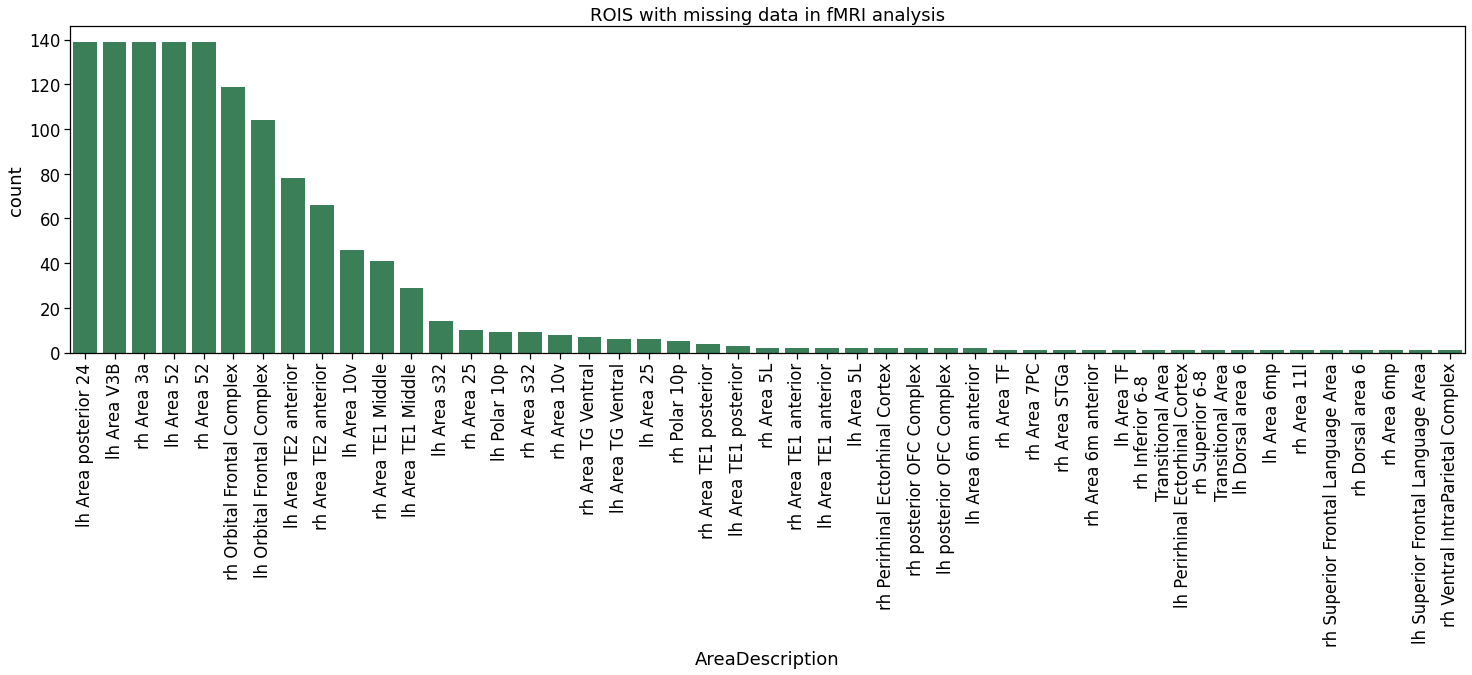

In [699]:
plt.figure(figsize=(25,6))
sns.barplot(x = 'AreaDescription', y = 'count', 
            data=func_missing_rois[func_missing_rois['count'] > 0],
            color='seagreen')
plt.title("ROIS with missing data in fMRI analysis")
plt.xticks(rotation = 90)
plt.show()

In [704]:
# visualize the number of missing regions 


missing_roi_map = np.zeros_like(hcp_data)
for i,roi in enumerate(hcp_rois): 
    missing_roi_map[hcp_data==(i+1)] = func_missing_rois.loc[roi, 'count']
missing_roi_img = nib.Nifti1Image(missing_roi_map, 
                           affine=hcp_orig_img.affine, 
                           header=hcp_orig_img.header)



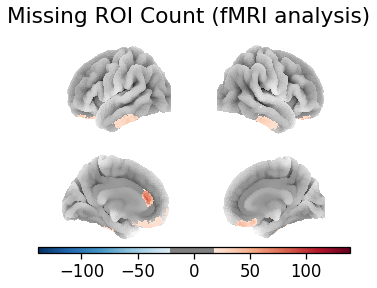

In [720]:
g = plotting.plot_img_on_surf(missing_roi_img,
                              cmap='RdBu_r',
                              title='Missing ROI Count (fMRI analysis)', 
                              threshold=20,
                              vmax=139
                              )
plt.show()

/Users/levitise2/env/dnu_bids/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

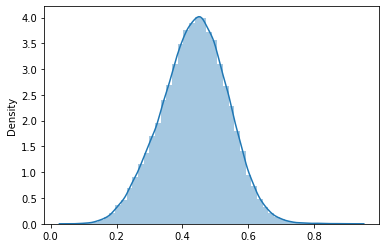

In [41]:
sns.distplot(np.array(reho_mean_glasser_df).flatten())

In [44]:
## save outputs 
alff_mean_glasser_df.to_csv("../../data/XXY/alff_mean_glasser.csv")
reho_mean_glasser_df.to_csv("../../data/XXY/reho_mean_glasser.csv")

In [46]:
x = pd.read_csv("/Users/levitise2/data/XXY/Nifti/derivatives/xcpOutputMNI/sub-NDARINVAJ501KPR/ses-v01/roiquant/glasser360/sub-NDARINVAJ501KPR_ses-v01_glasser360_mean_reho.csv")

In [47]:
x.columns[0:347]

Index(['id0', 'id1', 'anatomical_reho_mean_glasser360_Right_V1',
       'anatomical_reho_mean_glasser360_Right_MST',
       'anatomical_reho_mean_glasser360_Right_V6',
       'anatomical_reho_mean_glasser360_Right_V2',
       'anatomical_reho_mean_glasser360_Right_V3',
       'anatomical_reho_mean_glasser360_Right_V4',
       'anatomical_reho_mean_glasser360_Right_V8',
       'anatomical_reho_mean_glasser360_Right_4',
       ...
       'anatomical_reho_mean_glasser360_Left_31a',
       'anatomical_reho_mean_glasser360_Left_VVC',
       'anatomical_reho_mean_glasser360_Left_25',
       'anatomical_reho_mean_glasser360_Left_s32',
       'anatomical_reho_mean_glasser360_Left_pOFC',
       'anatomical_reho_mean_glasser360_Left_PoI1',
       'anatomical_reho_mean_glasser360_Left_Ig',
       'anatomical_reho_mean_glasser360_Left_FOP5',
       'anatomical_reho_mean_glasser360_Left_p10p',
       'anatomical_reho_mean_glasser360_Left_p47r'],
      dtype='object', length=347)

/Users/levitise2/env/dnu_bids/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

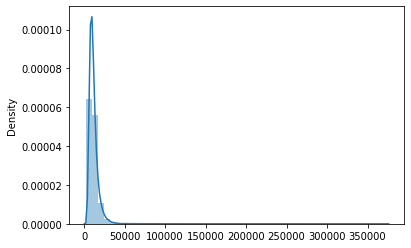

In [48]:
sns.distplot(np.array(alff_mean_glasser_df).flatten())

In [49]:
is_NaN = alff_mean_glasser_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = alff_mean_glasser_df[row_has_NaN]

In [50]:
reho_mean_glasser_df.head()

,lh_L_V1_ROI,lh_L_MST_ROI,lh_L_V6_ROI,lh_L_V2_ROI,lh_L_V3_ROI,lh_L_V4_ROI,lh_L_V8_ROI,lh_L_4_ROI,lh_L_3b_ROI,lh_L_FEF_ROI,...,rh_R_MBelt_ROI,rh_R_LBelt_ROI,rh_R_A4_ROI,rh_R_STSva_ROI,rh_R_PI_ROI,rh_R_a32pr_ROI,rh_R_p24_ROI,rh_R_TE1m_ROI,lh_L_TE1m_ROI,rh_R_10v_ROI
NDARINV8XENUGU9,0.569050,0.429141,0.574579,0.512325,0.534639,0.508310,0.498624,0.441101,0.460602,0.472939,...,0.434476,0.386572,0.450735,0.425669,0.299198,0.369220,0.485473,NaN,NaN,NaN
NDARINVAA410RM8,0.465255,0.478576,0.584810,0.409589,0.427376,0.438135,0.299562,0.446186,0.563558,0.570720,...,0.477547,0.392591,0.317588,0.312121,0.360569,0.348093,0.472673,0.354558,NaN,NaN
NDARINVAA761WNV,0.625324,0.683022,0.680593,0.593249,0.586016,0.593113,0.424864,0.613647,0.617442,0.463992,...,0.499232,0.507799,0.489372,0.447635,0.340344,0.428034,0.544622,0.174341,0.225164,NaN
NDARINVAD895ZW9,0.678504,0.673485,0.684257,0.606249,0.623282,0.576227,0.553533,0.632419,0.711597,0.553904,...,0.445823,0.539038,0.418501,0.414312,0.352529,0.462055,0.621329,NaN,NaN,0.501560
NDARINVAJ501KPR,0.432110,0.440430,0.392583,0.415240,0.382012,0.345400,0.339418,0.531445,0.622972,0.504014,...,0.419603,0.375859,0.365430,0.351977,0.341279,0.396576,0.368765,0.278683,0.174270,0.176118


## Quality control